In [1]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from collections import Counter
import os
import umap
import pickle
import partition_igraph
import subprocess
from sklearn.metrics import adjusted_mutual_info_score as AMI
import random 
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from abcd_graph import ABCDGraph, ABCDParams

## we use those for the book, but you can change to other colors
cls_edges = 'gainsboro'
cls = ['white','gray','dimgray','black']


In [22]:
## ABCD 
n = 10000

## degrees
gamma = 2.5
delta = 5
Delta = 50
zeta = np.log(Delta) / np.log(n)

## communities
beta = 1.5
s = 100
S = 8000
tau = np.log(S) / np.log(n)

xi = .65

np.random.seed(321)
random.seed(321)

G = ig.Graph()

params = ABCDParams(vcount=n, gamma=gamma, min_degree=delta, max_degree=Delta, beta=beta, min_community_size=s, max_community_size=S, xi=xi)
g = ABCDGraph(params).build()
G = g.exporter.to_igraph()
comms = G.vs['ground_truth_community'] 

print(AMI(G.community_ecg(ens_size=16, final='leiden').membership, G.vs['ground_truth_community']))


0.06511810345935758


In [23]:
import sknetwork as skn
from sknetwork.classification import get_accuracy_score

## classification
labels = np.array(G.vs['ground_truth_community'], dtype='int')
G_A = G.get_adjacency_sparse()
nc = np.max(G.vs['ground_truth_community'])+1

np.random.seed(123)
train_mask = np.random.random(size=len(labels)) < 0.5 ## mask nodes for training
labels[train_mask] = -1 ## the negative labels are ignored in the training

# GNN classifier with a single hidden layer
hidden_dim = 2*nc
n_labels = nc ## ground-truth communities 
gnn = skn.gnn.GNNClassifier(dims=[hidden_dim, n_labels],
                    layer_types='Conv',
                    activations='ReLu',
                    verbose=False)

## for features, we simply use the adjacency matrix
features = G_A

## fit the GCN
Pred = gnn.fit_predict(G_A, features, labels=labels, n_epochs=50, random_state=42)

## apply to test set and compute accuracy
acc = get_accuracy_score(np.array(G.vs['ground_truth_community'])[train_mask], Pred[train_mask])
print('accuracy on the test set:', acc)


accuracy on the test set: 0.7087613293051359


In [24]:
## misclassified vs degree and cluster size
misclass = [i for i in np.where(train_mask)[0] if (Pred[i] != G.vs['ground_truth_community'][i]) ]
correct = [i for i in np.where(train_mask)[0] if (Pred[i] == G.vs['ground_truth_community'][i]) ]
len(misclass)


1446

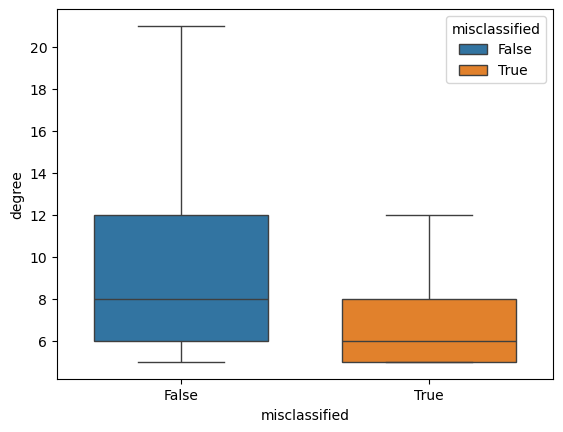

In [25]:
df = pd.DataFrame()
df['misclassified'] = [Pred[i] != G.vs['ground_truth_community'][i] for i in np.where(train_mask)[0]]
df['degree'] = G.degree(np.where(train_mask)[0])
sns.boxplot(df, x='misclassified', y='degree', showfliers=False, hue='misclassified', width=.7)
plt.show()


In [26]:
comm_sizes = Counter(G.vs['ground_truth_community'])
G.vs['comm_size'] = [comm_sizes[i] for i in G.vs['ground_truth_community']]
comm_sizes

Counter({0: 3772,
         1: 1493,
         2: 580,
         3: 551,
         4: 487,
         5: 446,
         6: 366,
         7: 311,
         8: 303,
         9: 261,
         10: 178,
         11: 151,
         12: 150,
         13: 136,
         14: 131,
         15: 125,
         16: 124,
         17: 119,
         18: 107,
         19: 106,
         20: 103})

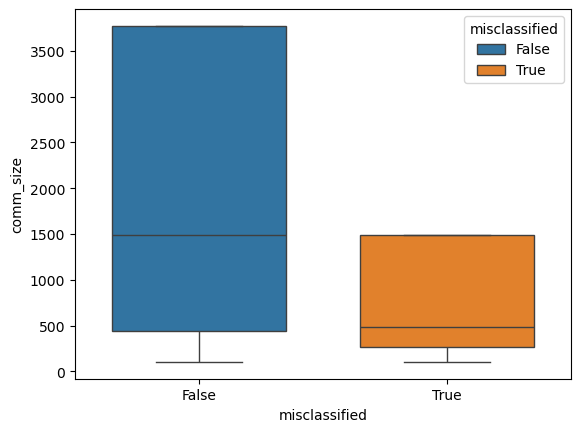

In [27]:
df['comm_size'] = [G.vs['comm_size'][i] for i in np.where(train_mask)[0]]
sns.boxplot(df, x='misclassified', y='comm_size', showfliers=False, hue='misclassified', width=.7)
plt.show()


In [37]:
df['pred_comm_size'] = [comm_sizes[Pred[i]] for i in np.where(train_mask)[0]]
df

,misclassified,degree,comm_size,pred_comm_size
0,False,7,3772,3772
1,False,21,3772,3772
2,False,11,3772,3772
3,False,39,3772,3772
4,False,7,3772,3772
...,...,...,...,...
4960,True,7,103,487
4961,False,6,103,103
4962,True,6,103,3772
4963,True,5,103,3772


In [38]:
df.groupby(by='misclassified').mean()

,degree,comm_size,pred_comm_size
misclassified,,,
False,10.866155,2088.058539,2088.058539
True,7.515214,1158.734440,2251.646611


In [44]:
Counter(df[df.misclassified==True]['comm_size'] < df[df.misclassified==True]['pred_comm_size'])

Counter({True: 995, False: 451})

In [56]:
Counter(df[ (df.comm_size==103) & (df.misclassified==True) ]['pred_comm_size'])

Counter({3772: 17, 1493: 5, 487: 3, 119: 2, 580: 1, 303: 1, 446: 1})